In [2]:
# load packages
import pandas as pd
import statsmodels.tsa.stattools as stats
import statsmodels.graphics.tsaplots as sg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sys
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

sys.path.append("../pipelines")
import Pipelines as tdw

//anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
roc_list = pd.read_pickle('gardner_rf_roc.pkl')
pr_list = pd.read_pickle('gardner_rf_pr.pkl')
rankings = pd.read_pickle('gardner_rf_rankings.pkl')
s_roc_list = pd.read_pickle('gardner_swing_rf_roc.pkl')
s_pr_list = pd.read_pickle('gardner_swing_rf_pr.pkl')
s_rankings = pd.read_pickle('gardner_swing_rf_rankings.pkl')
preexisting = True

In [4]:
data_folder = "../data/invitro/"

output_path = "../data/invitro/"

current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

file_path = "../data/invitro/gardner_timeseries.tsv"
run_params = {'data_folder': data_folder,
              'file_path':file_path,
              'td_window':14,
              'min_lag':0,
              'max_lag':0,
              'n_trees':1000,
              'permutation_n':None,
              'lag_method':'mean_mean',
              'calc_mse':False,
              'bootstrap_n':1000,
              'n_trials':1,
              'run_time':current_time,
              'sort_by':'rank',
              'iterating_param':'td_window',
              }

if not preexisting:
    roc_list =[]
    pr_list = []
    rankings = []
    for ii in range(50):
        print("Run: ", str(ii))
        roc, pr, tdr, edge_list = tdw.get_td_stats(**run_params)
        roc_list.append(roc)
        pr_list.append(pr)
        rankings.append(edge_list)
    pd.to_pickle(roc_list, 'gardner_rf_roc.pkl')
    pd.to_pickle(pr_list, 'gardner_rf_pr.pkl')
    pd.to_pickle(rankings, 'gardner_rf_rankings.pkl')

In [5]:
data_folder = "../data/invitro/"

output_path = "../data/invitro/"

current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

file_path = "../data/invitro/gardner_timeseries.tsv"
run_params = {'data_folder': data_folder,
              'file_path':file_path,
              'td_window':10,
              'min_lag':0,
              'max_lag':1,
              'n_trees':1000,
              'permutation_n':None,
              'lag_method':'mean_mean',
              'calc_mse':False,
              'bootstrap_n':1000,
              'n_trials':1,
              'run_time':current_time,
              'sort_by':'rank',
              'iterating_param':'td_window',
              }

if not preexisting:
    s_roc_list =[]
    s_pr_list = []
    s_rankings = []
    for ii in range(50):
        print("Run: ", str(ii))
        roc, pr, tdr, edge_list = tdw.get_td_stats(**run_params)
        s_roc_list.append(roc)
        s_pr_list.append(pr)
        s_rankings.append(edge_list)

    pd.to_pickle(s_roc_list, 'gardner_swing_rf_roc.pkl')
    pd.to_pickle(s_pr_list, 'gardner_swing_rf_pr.pkl')
    pd.to_pickle(s_rankings, 'gardner_swing_rf_rankings.pkl')

0.755729166667 0.8275 1.09496898691 MannwhitneyuResult(statistic=0.0, pvalue=3.4666982611037811e-18)
0.285516127416 0.330085849965 1.1561022943 MannwhitneyuResult(statistic=398.0, pvalue=2.1778243644974499e-09)


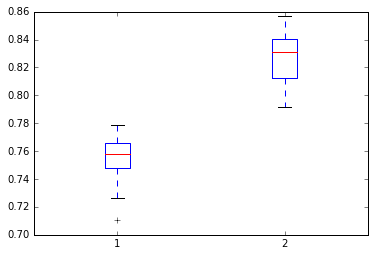

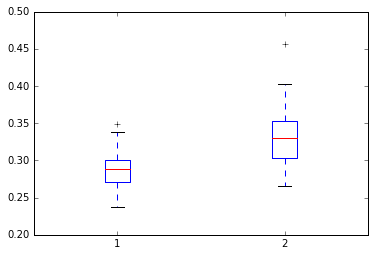

In [12]:
from scipy.stats import fisher_exact, linregress, ttest_rel, mannwhitneyu
plt.boxplot([roc_list, s_roc_list])
print(np.mean(roc_list), np.mean(s_roc_list), np.mean(s_roc_list)/np.mean(roc_list),  mannwhitneyu(roc_list, s_roc_list))
plt.figure()
plt.boxplot([pr_list, s_pr_list])
print(np.mean(pr_list), np.mean(s_pr_list), np.mean(s_pr_list)/np.mean(pr_list), mannwhitneyu(pr_list, s_pr_list))

In [7]:
# Average the rankings together to see if the mean result is better too
avg_rank = pd.DataFrame()
s_avg_rank = pd.DataFrame()
avg_rank['regulator-target'] = rankings[0].sort_values('regulator-target').values[:,0]
s_avg_rank['regulator-target'] = s_rankings[0].sort_values('regulator-target').values[:,0]
rank = np.array([rankings[ii].sort_values('regulator-target')['Rank'].values for ii in range(len(rankings))]).T
avg_rank['rank'] = np.mean(rank, axis=1)
s_rank = np.array([s_rankings[ii].sort_values('regulator-target')['Rank'].values for ii in range(len(s_rankings))]).T
s_avg_rank['rank'] = np.mean(s_rank, axis=1)

In [8]:
from Swing.util.Evaluator import Evaluator

In [9]:
evaluator = Evaluator("../data/invitro/gardner_goldstandard.tsv", '\t')
auroc = evaluator.calc_roc(avg_rank.sort_values('rank'))[2].values[-1]
s_auroc = evaluator.calc_roc(s_avg_rank.sort_values('rank'))[2].values[-1]
print(auroc, s_auroc)

0.7578125 0.830729166667


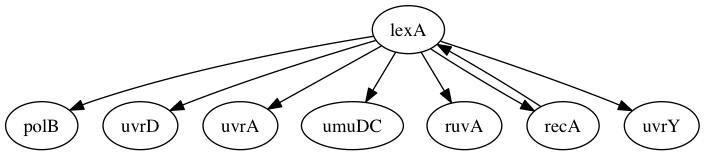

In [10]:
dg = nx.DiGraph()
dg.add_edges_from(evaluator.gs_flat)
draw(dg)